<a href="https://colab.research.google.com/github/JaquelineFGomesJardim/Previsao_demanda/blob/main/PREVISAO_DEMANDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparação do ambiente

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q findspark pyspark

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("previsaodemanda") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
print("Spark configurado corretamente!")

Spark configurado corretamente!


# Importando as bibliotecas

In [4]:
import os
import sys
import pytz
import numpy as np
import pandas as pd
import datetime
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf, lpad, translate
from datetime import datetime
from datetime import timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, col, to_date, trim, when,sum, min, max,lit,to_timestamp, year, date_format,split, lpad, concat_ws
from pyspark.sql import functions as F
import builtins
import pyspark.sql.types as T

# Leitura e Governança dos Dados

In [5]:
tz       = pytz.timezone("Europe/Lisbon")
agora    = datetime.now(tz)
dthproc  = agora.strftime("%Y%m%d%H%M%S")
file     = f'previsao_demanda_{dthproc}.csv'
ts_file_generation = file.split("_")[-1].replace('.csv','') + '00'
print("ts_file_generation =", ts_file_generation)

ts_file_generation = 2025060323390000


In [6]:
base_dir        = "/content/drive/MyDrive/PREVISAO_DEMANDA"
controle_dir    = os.path.join(base_dir, "CONTROLE", f"tb_controle_procesamento_{dthproc}")
metadados_dir   = os.path.join(base_dir, "METADADOS")

In [7]:
path_input = os.path.join(base_dir, "Historical_Product_Demand.csv")
abt_demanda = spark.read.csv(
    path_input,
    header=True,
    inferSchema=True
)
abt_demanda.createOrReplaceTempView("abt_demanda")
abt_demanda.cache()
qtd = abt_demanda.count()
print("records abt_demanda:", qtd)

records abt_demanda: 1048575


In [8]:
controle = spark.sql(f"""
  SELECT
    '{file}'               AS name_file,
    {qtd}                  AS qtd_records,
    '{dthproc}'            AS ts_proc,
    '{ts_file_generation}' AS ts_file_generation
""")

controle.write \
    .mode("append") \
    .partitionBy("ts_proc") \
    .parquet(controle_dir)
print("Controle gravado em:", controle_dir)

Controle gravado em: /content/drive/MyDrive/PREVISAO_DEMANDA/CONTROLE/tb_controle_procesamento_20250603233900


# EDA

### Visualização dos dados:

In [9]:
abt_demanda.show()

+------------+---------+----------------+----------+------------+
|Product_Code|Warehouse|Product_Category|      Date|Order_Demand|
+------------+---------+----------------+----------+------------+
|Product_0993|   Whse_J|    Category_028| 2012/7/27|        100 |
|Product_0979|   Whse_J|    Category_028| 2012/1/19|        500 |
|Product_0979|   Whse_J|    Category_028|  2012/2/3|        500 |
|Product_0979|   Whse_J|    Category_028|  2012/2/9|        500 |
|Product_0979|   Whse_J|    Category_028|  2012/3/2|        500 |
|Product_0979|   Whse_J|    Category_028| 2012/4/19|        500 |
|Product_0979|   Whse_J|    Category_028|  2012/6/5|        500 |
|Product_0979|   Whse_J|    Category_028| 2012/6/27|        500 |
|Product_0979|   Whse_J|    Category_028| 2012/7/23|        500 |
|Product_0979|   Whse_J|    Category_028| 2012/8/29|        500 |
|Product_0979|   Whse_J|    Category_028| 2012/8/29|        500 |
|Product_0979|   Whse_J|    Category_028| 2012/9/18|        500 |
|Product_0

# Metadados

In [10]:
def generate_metadados(dataframe):
    # Nome das colunas
    column_names = dataframe.columns

    # Tipo de dados das colunas
    dtypes = [dtype for _, dtype in dataframe.dtypes]

    # Contagem de valores nulos
    null_counts = [dataframe.filter(F.col(c).isNull()).count() for c in column_names]

    # Percentual de valores nulos
    total_count = dataframe.count()
    null_percents = [round((null_count / total_count) * 100, 2) for null_count in null_counts]

    # Cardinalidade (número de valores únicos)
    cardinality = [dataframe.select(c).distinct().count() for c in column_names]

    # Criar um DataFrame PySpark com as informações
    metadata = spark.createDataFrame(
        zip(column_names, dtypes, null_counts, null_percents, cardinality),
        schema=["nome_variavel", "tipo", "qt_nulos", "percent_nulos", "cardinalidade"]
    )

    # Ordenar pelo tipo
    metadata = metadata.orderBy(F.desc("percent_nulos"))

    return metadata


In [11]:
metadata_df = generate_metadados(abt_demanda)
metadata_df.show(10, truncate=False)

+----------------+------+--------+-------------+-------------+
|nome_variavel   |tipo  |qt_nulos|percent_nulos|cardinalidade|
+----------------+------+--------+-------------+-------------+
|Product_Code    |string|0       |0.0          |2160         |
|Product_Category|string|0       |0.0          |33           |
|Warehouse       |string|0       |0.0          |4            |
|Date            |string|0       |0.0          |1730         |
|Order_Demand    |string|0       |0.0          |3828         |
+----------------+------+--------+-------------+-------------+



In [12]:
path_metadados = os.path.join(metadados_dir, f"tb_metadados_inicial_{dthproc}")

md = metadata_df.withColumn("dthproc", lit(dthproc))

md.write \
    .mode("append") \
    .partitionBy("dthproc") \
    .parquet(path_metadados)
print("Metadados gravados em:", path_metadados)

Metadados gravados em: /content/drive/MyDrive/PREVISAO_DEMANDA/METADADOS/tb_metadados_inicial_20250603233900


## Correção do dtype da variável Order_Demand, e o formato da data conforme visto no metadados:
* Extração do ano e ano/mês para realizarmos a análise dos dados.


In [13]:
abt_demanda.createOrReplaceTempView("abt_demanda")


In [14]:
train_abt_demanda = abt_demanda.withColumn(
    "iso_date",
    concat_ws("-",
        split(col("Date"), "/")[0],
        lpad(split(col("Date"), "/")[1], 2, "0"),
        lpad(split(col("Date"), "/")[2], 2, "0")
    )
)

In [15]:
train_abt_demanda.show()

+------------+---------+----------------+----------+------------+----------+
|Product_Code|Warehouse|Product_Category|      Date|Order_Demand|  iso_date|
+------------+---------+----------------+----------+------------+----------+
|Product_0993|   Whse_J|    Category_028| 2012/7/27|        100 |2012-07-27|
|Product_0979|   Whse_J|    Category_028| 2012/1/19|        500 |2012-01-19|
|Product_0979|   Whse_J|    Category_028|  2012/2/3|        500 |2012-02-03|
|Product_0979|   Whse_J|    Category_028|  2012/2/9|        500 |2012-02-09|
|Product_0979|   Whse_J|    Category_028|  2012/3/2|        500 |2012-03-02|
|Product_0979|   Whse_J|    Category_028| 2012/4/19|        500 |2012-04-19|
|Product_0979|   Whse_J|    Category_028|  2012/6/5|        500 |2012-06-05|
|Product_0979|   Whse_J|    Category_028| 2012/6/27|        500 |2012-06-27|
|Product_0979|   Whse_J|    Category_028| 2012/7/23|        500 |2012-07-23|
|Product_0979|   Whse_J|    Category_028| 2012/8/29|        500 |2012-08-29|

In [16]:
train_abt_demanda = train_abt_demanda \
    .withColumn("date", to_date(col("iso_date"), "yyyy-MM-dd")) \
    .withColumn("year", year(col("date"))) \
    .withColumn("month_reference", date_format(col("date"), "yyyyMM")) \
    .withColumn("Order_Demand", col("Order_Demand").cast("integer")) \
    .drop("Date")

train_abt_demanda.printSchema()
train_abt_demanda.show(truncate=False)
train_abt_demanda.createOrReplaceTempView('train_abt_demanda')

root
 |-- Product_Code: string (nullable = true)
 |-- Warehouse: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Order_Demand: integer (nullable = true)
 |-- iso_date: string (nullable = false)
 |-- year: integer (nullable = true)
 |-- month_reference: string (nullable = true)

+------------+---------+----------------+------------+----------+----+---------------+
|Product_Code|Warehouse|Product_Category|Order_Demand|iso_date  |year|month_reference|
+------------+---------+----------------+------------+----------+----+---------------+
|Product_0993|Whse_J   |Category_028    |100         |2012-07-27|2012|201207         |
|Product_0979|Whse_J   |Category_028    |500         |2012-01-19|2012|201201         |
|Product_0979|Whse_J   |Category_028    |500         |2012-02-03|2012|201202         |
|Product_0979|Whse_J   |Category_028    |500         |2012-02-09|2012|201202         |
|Product_0979|Whse_J   |Category_028    |500         |2012-03-02|2012|201203      

* Corringindo o dtype da variável iso_date e renomeando.

In [17]:
train_abt_demanda_00 = train_abt_demanda \
    .withColumn("Date", to_date(col("iso_date"), "yyyy-MM-dd")) \
    .drop("iso_date")

train_abt_demanda_00.show(truncate=False)
train_abt_demanda_00.createOrReplaceTempView('train_abt_demanda_00')

+------------+---------+----------------+------------+----+---------------+----------+
|Product_Code|Warehouse|Product_Category|Order_Demand|year|month_reference|Date      |
+------------+---------+----------------+------------+----+---------------+----------+
|Product_0993|Whse_J   |Category_028    |100         |2012|201207         |2012-07-27|
|Product_0979|Whse_J   |Category_028    |500         |2012|201201         |2012-01-19|
|Product_0979|Whse_J   |Category_028    |500         |2012|201202         |2012-02-03|
|Product_0979|Whse_J   |Category_028    |500         |2012|201202         |2012-02-09|
|Product_0979|Whse_J   |Category_028    |500         |2012|201203         |2012-03-02|
|Product_0979|Whse_J   |Category_028    |500         |2012|201204         |2012-04-19|
|Product_0979|Whse_J   |Category_028    |500         |2012|201206         |2012-06-05|
|Product_0979|Whse_J   |Category_028    |500         |2012|201206         |2012-06-27|
|Product_0979|Whse_J   |Category_028    |50

## Contagem dos nulos na variável Date e Order_Demand por Armazém .

In [18]:
spark.sql("""
  SELECT
    Warehouse,
    COUNT(*)  AS total_linhas,
    SUM(CASE WHEN Date IS NULL THEN 1 ELSE 0 END) AS nulls_date,
    SUM(CASE WHEN Date = 'NA' THEN 1 ELSE 0 END) AS nulls_na,
    SUM(CASE WHEN Order_Demand IS NULL THEN 1 ELSE 0 END) AS nulls_order_demand,
    ROUND(100.0 * SUM(CASE WHEN Date IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_nulls,
    ROUND(100.0 * SUM(CASE WHEN Date = 'NA' THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_na,
    ROUND(100.0 * SUM(CASE WHEN Order_Demand IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_nulls_order_demand
  FROM train_abt_demanda_00
  GROUP BY Warehouse
  ORDER BY nulls_date DESC
""").show(truncate=False)

+---------+------------+----------+--------+------------------+---------+------+----------------------+
|Warehouse|total_linhas|nulls_date|nulls_na|nulls_order_demand|pct_nulls|pct_na|pct_nulls_order_demand|
+---------+------------+----------+--------+------------------+---------+------+----------------------+
|Whse_A   |153574      |11239     |0       |6395              |7.32     |0.00  |4.16                  |
|Whse_C   |42354       |0         |0       |117               |0.00     |0.00  |0.28                  |
|Whse_J   |764447      |0         |0       |3555              |0.00     |0.00  |0.47                  |
|Whse_S   |88200       |0         |0       |402               |0.00     |0.00  |0.46                  |
+---------+------------+----------+--------+------------------+---------+------+----------------------+



* O Armazém Whse_A, é O único que contém datas null, que corresponde a 7,32%, ou seja, um percentual baixo para um total de 153574 linhas de registros. E Possui null também na variável nulls_order_demand, 4,16%, percentual baixo também.
Vamos ver a data mínima e máxima que estão no DF.

In [19]:
train_abt_demanda_00.agg(
    min("Date").alias("min_date"),
    max("Date").alias("max_date")
).show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2011-01-08|2017-01-09|
+----------+----------+



# Visualização por gráficos:

In [20]:
train_pandas = train_abt_demanda_00.toPandas()

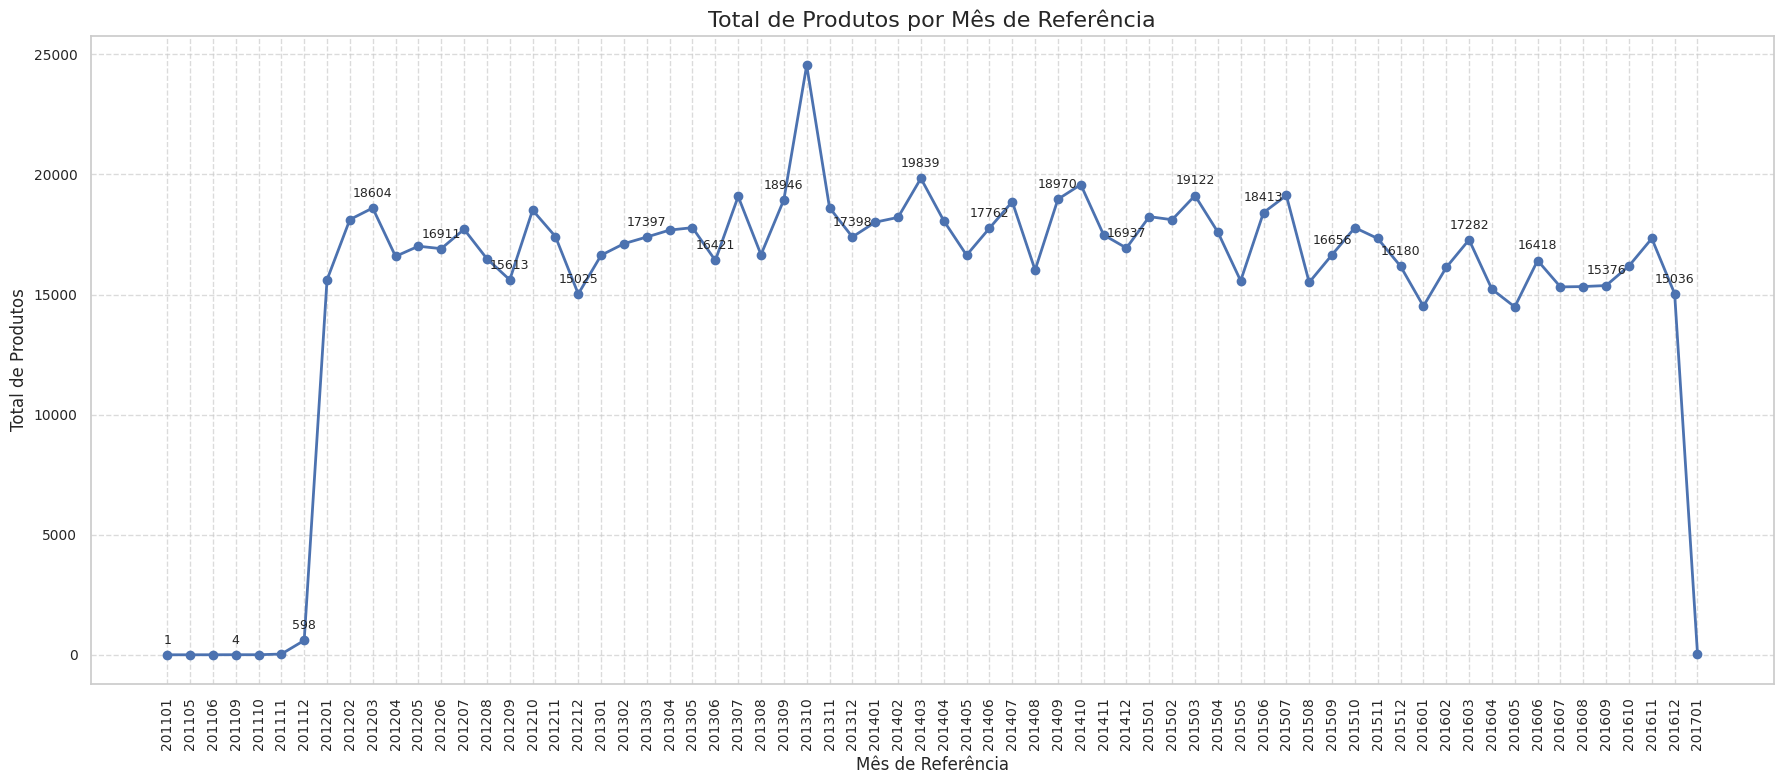

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mantém o estilo seaborn
sns.set(style="whitegrid")

# 1) Agrega: conta quantas linhas há em cada mês
df_monthly = (
    train_pandas
      .groupby('month_reference')
      .size()
      .reset_index(name='total_products')
)

# 2) Garante que o mês está em ordem cronológica
df_monthly = df_monthly.sort_values('month_reference')

# 3) Plot
plt.figure(figsize=(18, 8))
plt.plot(
    df_monthly['month_reference'].astype(str),
    df_monthly['total_products'],
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=6
)
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Total de Produtos', fontsize=12)
plt.title('Total de Produtos por Mês de Referência', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Anotações a cada 3 meses, por exemplo
for i in range(0, len(df_monthly), 3):
    plt.annotate(
        df_monthly['total_products'].iloc[i],
        (df_monthly['month_reference'].astype(str).iloc[i],
         df_monthly['total_products'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 8),
        ha='center',
        fontsize=9
    )

plt.show()

## Gráfico 1 - Observações Produtos por safra:

* Os meses do ano de 2011, não possuem um histórico,podemos retirar do df.

* A partir de 01/2012 que realmente começa inicia a grande movimentação.

* Houve um pico em 10/2013 onde chegou atingir quase 25.000 produtos, porém, retornou a normalidade

* A partir de 08/2015 podemos enxergar uma leve queda no total de produtos que  mantem-se até o final do dataset.

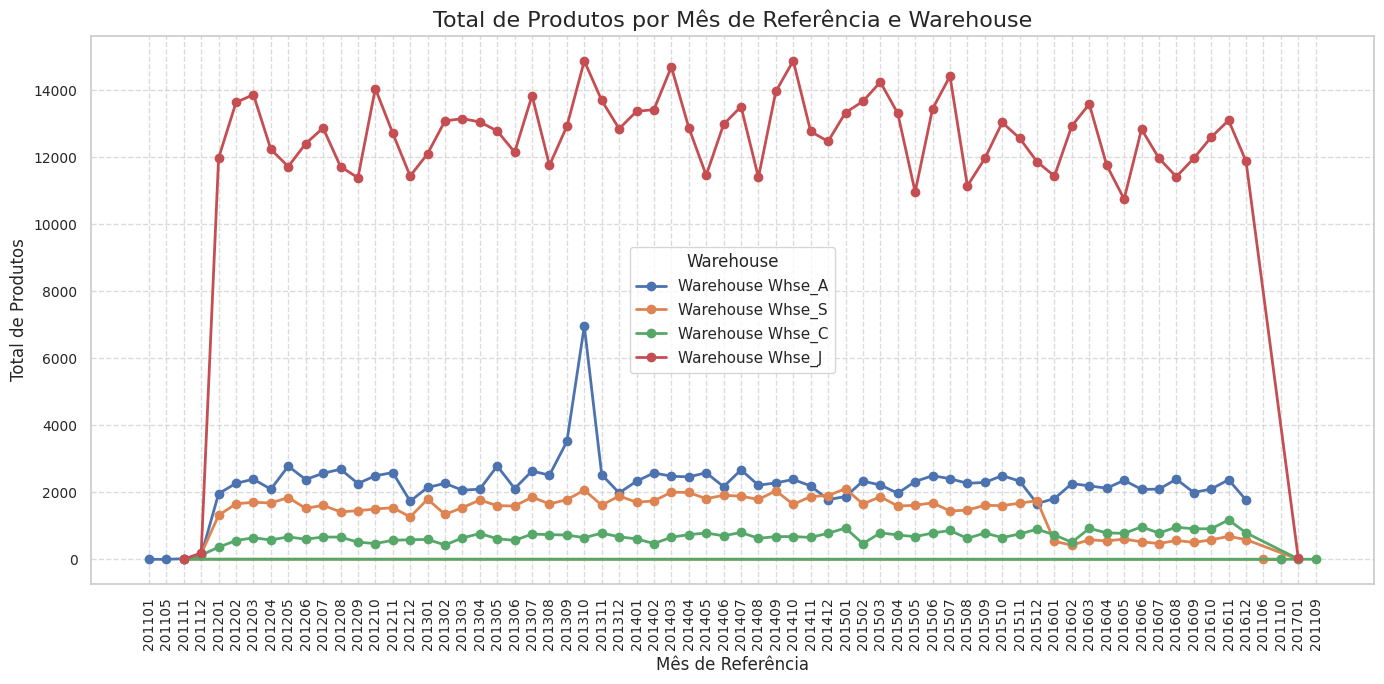

In [22]:
sns.set(style="whitegrid")

# Agrega e conta quantos registros existem por mês e warehouse
df_ref_wh = (
    train_pandas
      .groupby(['month_reference', 'Warehouse'])
      .size()
      .reset_index(name='Total_produtos')
)

# Ordena os meses cronologicamente
df_ref_wh = df_ref_wh.sort_values('month_reference')

# Plota
plt.figure(figsize=(14, 7))

for wh in df_ref_wh['Warehouse'].unique():
    wh_data = df_ref_wh[df_ref_wh['Warehouse'] == wh]
    plt.plot(
        wh_data['month_reference'],
        wh_data['Total_produtos'],
        marker='o',
        linestyle='-',
        linewidth=2,
        label=f'Warehouse {wh}'
    )

plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Total de Produtos', fontsize=12)
plt.title('Total de Produtos por Mês de Referência e Warehouse', fontsize=16)
plt.xticks(df_ref_wh['month_reference'].unique(), rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Warehouse')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


## Gráfico 2 - Observações Produtos por safra por armazém:

* Claramente podemos enxergar que o armazém Whse_J é o que mais movimenta os produtos, a demanda maior é concentrada nesse armazém, com vários picos.
* O armazém Whse_J nos meses 05/2014, 08/2014 teve um queda considerável o que se repete nos anos seguinte nos mesmos meses 05/2015, 08/2015, 05/2016 e 08/2016 mesmo que em 08/2016 a queda foi menor já conseguimos identificar um padrão talvez.

* Os armazéns Whse_A e Whse_S teem movimentações parecidas e bem próximas nas quantidades, apenas em 10/2013 o Whse_A teve um pico bem grande, e o Whse_S a partir de 01/2016 que caiu bastante a quantidade de produtos, ficando abaixo de todos os outros.
* Essa queda acontece também no Whse_J, com uma menor magnitude, enquanto o Whse_C e o Whse_A se mantém.

* O armazém Whse_C tem uma movimentação estável sempre, e bem baixa, em comparaçao com todos os outros.

De forma geral, o armazém que mais tem altos e baixos é o Whse_J, mas conseguimos identificar um padrão em todos os anos nas quedas, o Whse_A e o Whse_S possem uma movimentação bem parecida, exceto a artir do ano 2016, e o Whse_C é sempre com o mesmo padrão no dataset.

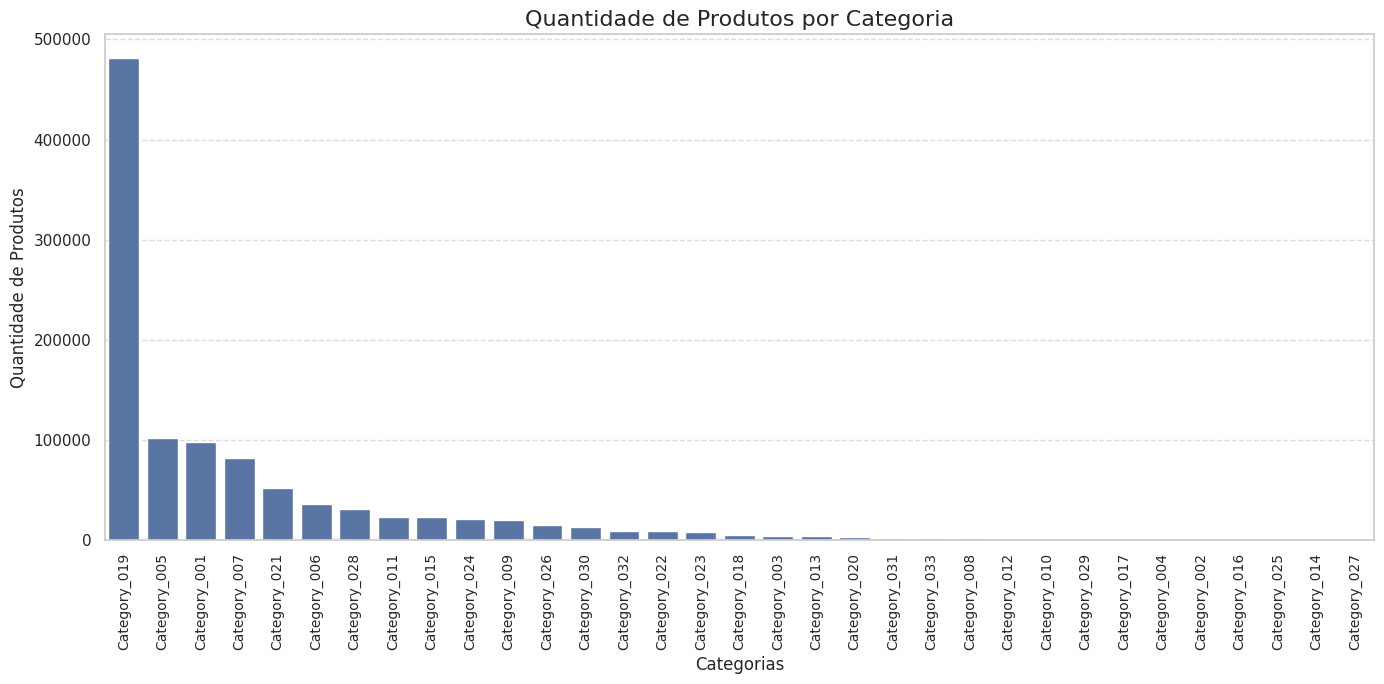

In [23]:
sns.set(style="whitegrid")

# Agrega registros (Product_Code) em cada Product_Category
df_category_counts = (
    train_pandas
      .groupby('Product_Category')['Product_Code']
      .count()
      .reset_index(name='count')
)

# 2) Ordena categorias por contagem decrescente
df_category_counts = df_category_counts.sort_values('count', ascending=False)

# 3) Plot de barras
plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_category_counts,
    x='Product_Category',
    y='count'
)

plt.xlabel('Categorias', fontsize=12)
plt.ylabel('Quantidade de Produtos', fontsize=12)
plt.title('Quantidade de Produtos por Categoria', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.tight_layout()
plt.show()

## Gráfico 3 - Observações por categoria:

* Claramente a catgria 019 lidera, disparado, das outras, ou seja ela impacta bastante, mas não sabemos se todos os armazéns.
* Depois temos 2 categorias, 005 e 001, na mesma faixa, a categoria 007 um pouco abaixo das duas e a 021 já na metade das duas.
* As demais vão caindo gradualmente.


# Vamos olhar por armazém:

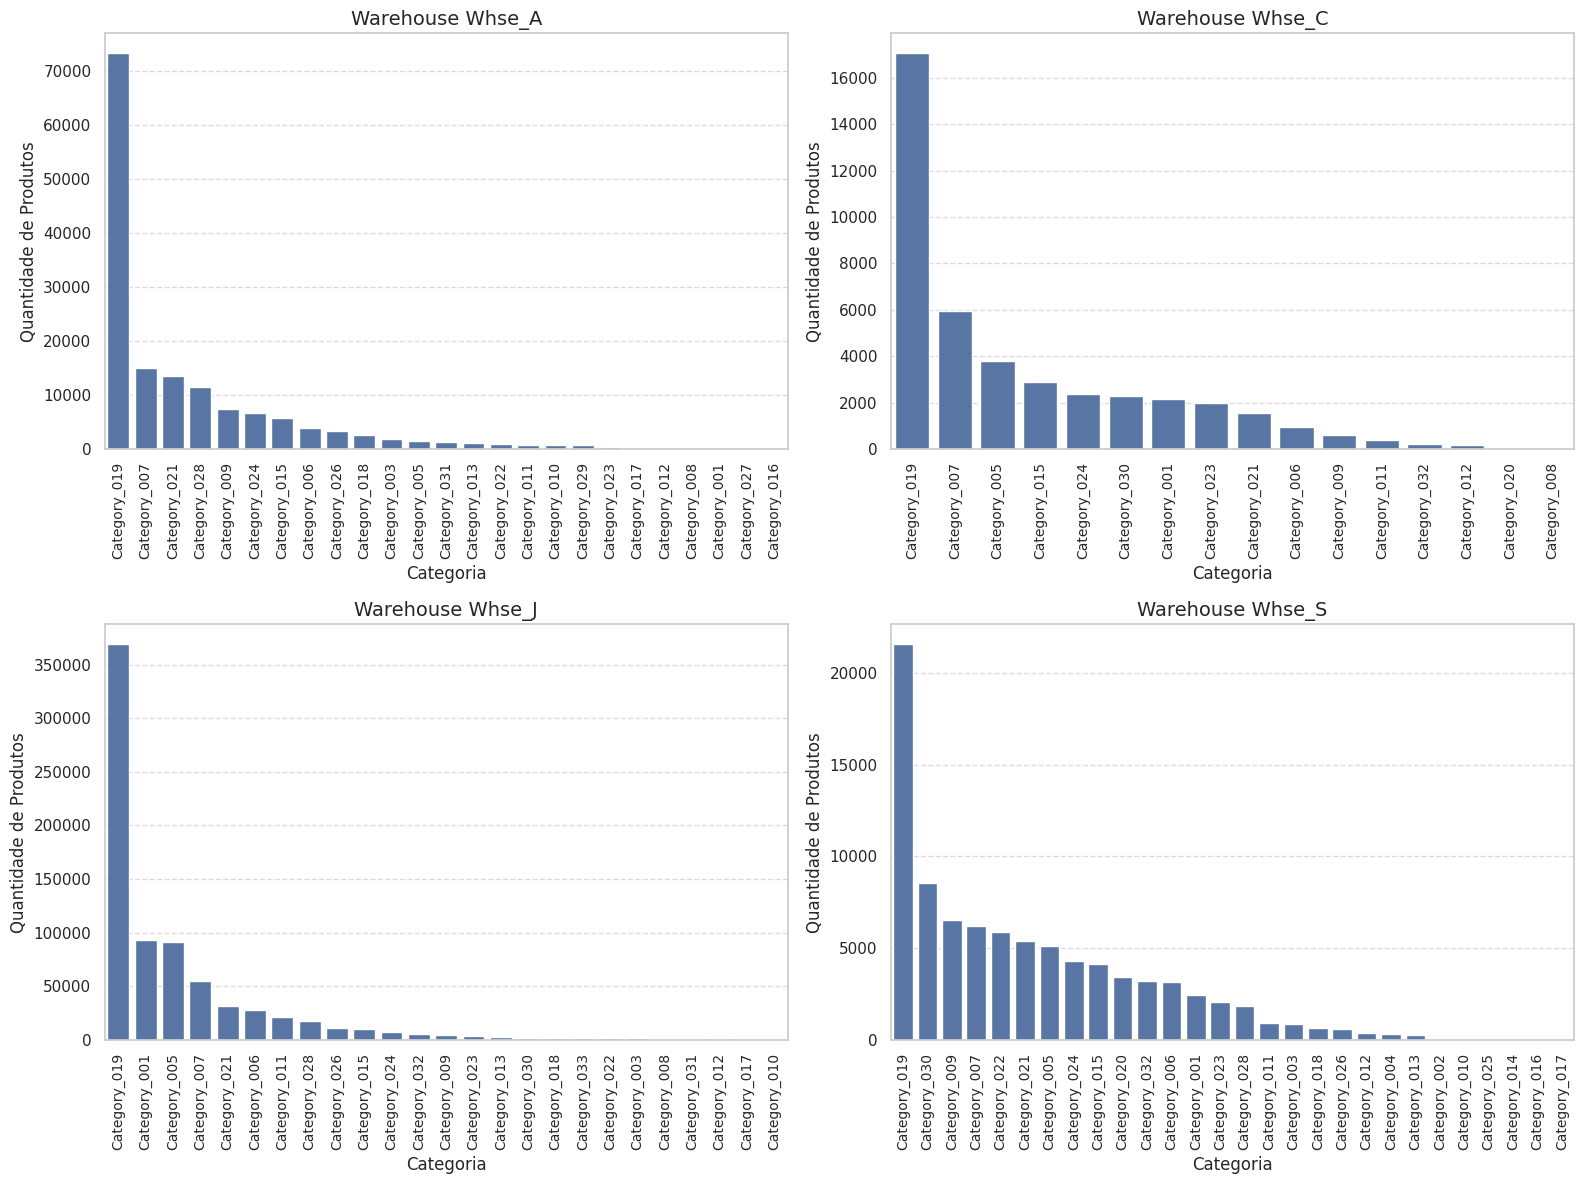

In [24]:
# DataFrame pandas train_pandas
sns.set(style="whitegrid")

# 2) Agrupa por Warehouse e Product_Category para contar Product_Code
df_cat_wh_counts = (
    train_pandas
      .groupby(['Warehouse', 'Product_Category'])['Product_Code']
      .count()
      .reset_index(name='count')
)

# Lista de warehouses únicas
warehouses = df_cat_wh_counts['Warehouse'].unique()

# Cria subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Para cada warehouse, filtra os dados e plota o barplot
for ax, wh in zip(axes, warehouses):
    data_wh = (
        df_cat_wh_counts
          .loc[df_cat_wh_counts['Warehouse'] == wh]
          .sort_values('count', ascending=False)
    )
    sns.barplot(
        data=data_wh,
        x='Product_Category',
        y='count',
        ax=ax
    )
    ax.set_title(f'Warehouse {wh}', fontsize=14)
    ax.set_xlabel('Categoria', fontsize=12)
    ax.set_ylabel('Quantidade de Produtos', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# Remove eixos extras
for idx in range(len(warehouses), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


## Gráfico 4 - Observações:

Realmente a categoria 019 sobressai em todos os armazéns, porém a sequência, a partir da segunda categoria muda, cada armazém tem sua própria sequência.

### Retirando o ano de 2011, e salvando a nova tabela de dados.

In [25]:
df_train= spark.sql("""
  SELECT *
    FROM train_abt_demanda_00
   WHERE COALESCE(year, 0) <> 2011
""")

df_train.show()

+------------+---------+----------------+------------+----+---------------+----------+
|Product_Code|Warehouse|Product_Category|Order_Demand|year|month_reference|      Date|
+------------+---------+----------------+------------+----+---------------+----------+
|Product_0993|   Whse_J|    Category_028|         100|2012|         201207|2012-07-27|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201201|2012-01-19|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201202|2012-02-03|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201202|2012-02-09|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201203|2012-03-02|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201204|2012-04-19|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201206|2012-06-05|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201206|2012-06-27|
|Product_0979|   Whse_J|    Category_028|  

# Check de sanidade!

In [26]:
df_train.agg(
    min("Date").alias("min_date"),
    max("Date").alias("max_date")
).show()
qtd = df_train.count()
print("records df_train:", qtd)

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2012-01-01|2017-01-09|
+----------+----------+

records df_train: 1047935


# Metadados

In [27]:
metadata_df = generate_metadados(df_train)
metadata_df.show(10, truncate=False)

+----------------+------+--------+-------------+-------------+
|nome_variavel   |tipo  |qt_nulos|percent_nulos|cardinalidade|
+----------------+------+--------+-------------+-------------+
|year            |int   |11239   |1.07         |7            |
|month_reference |string|11239   |1.07         |62           |
|Date            |date  |11239   |1.07         |1688         |
|Order_Demand    |int   |10429   |1.0          |3286         |
|Product_Code    |string|0       |0.0          |2160         |
|Warehouse       |string|0       |0.0          |4            |
|Product_Category|string|0       |0.0          |33           |
+----------------+------+--------+-------------+-------------+



* Olhando esse metadados, conseguimos ver a redução de nulos na variável Order_Demand, antes o total era de 5.37% após fazer a retirada do ano de 2011 resultou em 1% no dataframe.
Podemos retirar tambem, nesse caso, os registros que estão com data null, pois os graficos já nos trouxeram uma visualização sem esses registros, e para nossa pervisão a data é um dado chave, sem ele não conseguimos utilizar os registros.

# Retirando do DF o ano 2011

In [28]:
df_train= spark.sql("""
  SELECT *
    FROM train_abt_demanda_00
   WHERE year <> 2011
""")

df_train.show()

+------------+---------+----------------+------------+----+---------------+----------+
|Product_Code|Warehouse|Product_Category|Order_Demand|year|month_reference|      Date|
+------------+---------+----------------+------------+----+---------------+----------+
|Product_0993|   Whse_J|    Category_028|         100|2012|         201207|2012-07-27|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201201|2012-01-19|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201202|2012-02-03|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201202|2012-02-09|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201203|2012-03-02|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201204|2012-04-19|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201206|2012-06-05|
|Product_0979|   Whse_J|    Category_028|         500|2012|         201206|2012-06-27|
|Product_0979|   Whse_J|    Category_028|  

# Check de sanidade!

In [29]:
qtd = df_train.count()
print("records df_train:", qtd)

records df_train: 1036696


# Removendo os Sufixos

* Agora vamos retirar os sufixos das váriaveis: Product_Code , Warehouse e Product_Category, para que nosso DF fique somente com números, que é muiro importante para a modelagem, e nesse caso podemos retirar o sufixo sem alterar a qualidade, o conteúdo e a explicabilidade dos dados.
E corrigir o dtype das mesmas.

In [30]:
from pyspark.sql.functions import regexp_replace

df_train = df_train \
    .withColumn(
        "Product_Code",
        regexp_replace(col("Product_Code"), "^Product_", "")
    ) \
    .withColumn(
        "Warehouse",
        regexp_replace(col("Warehouse"), "^Whse_", "")
    ) \
    .withColumn(
        "Product_Category",
        regexp_replace(col("Product_Category"), "^Category_", "")
    )

df_train.show(truncate=False)


+------------+---------+----------------+------------+----+---------------+----------+
|Product_Code|Warehouse|Product_Category|Order_Demand|year|month_reference|Date      |
+------------+---------+----------------+------------+----+---------------+----------+
|0993        |J        |028             |100         |2012|201207         |2012-07-27|
|0979        |J        |028             |500         |2012|201201         |2012-01-19|
|0979        |J        |028             |500         |2012|201202         |2012-02-03|
|0979        |J        |028             |500         |2012|201202         |2012-02-09|
|0979        |J        |028             |500         |2012|201203         |2012-03-02|
|0979        |J        |028             |500         |2012|201204         |2012-04-19|
|0979        |J        |028             |500         |2012|201206         |2012-06-05|
|0979        |J        |028             |500         |2012|201206         |2012-06-27|
|0979        |J        |028             |50

In [31]:
df_train = df_train \
    .withColumn("Product_Code", col("Product_Code").cast("int")) \
    .withColumn("Product_Category", col("Product_Category").cast("int"))

# Check de sanidade!

In [32]:
qtd = df_train.count()
print("records df_train:", qtd)

records df_train: 1036696


### Salvando o metadados final.

In [33]:
metadata_df = generate_metadados(df_train)
metadata_df.show(10, truncate=False)

+----------------+------+--------+-------------+-------------+
|nome_variavel   |tipo  |qt_nulos|percent_nulos|cardinalidade|
+----------------+------+--------+-------------+-------------+
|Order_Demand    |int   |5859    |0.57         |3281         |
|Product_Code    |int   |0       |0.0          |2160         |
|year            |int   |0       |0.0          |6            |
|Warehouse       |string|0       |0.0          |4            |
|month_reference |string|0       |0.0          |61           |
|Product_Category|int   |0       |0.0          |33           |
|Date            |date  |0       |0.0          |1687         |
+----------------+------+--------+-------------+-------------+



Agora sim vamos salvar os metadados finais, com a variável Date sem nulos.

In [34]:
path_metadados = os.path.join(metadados_dir, f"tb_metadados_final_{dthproc}")

md = metadata_df.withColumn("dthproc", lit(dthproc))

md.write \
    .mode("append") \
    .partitionBy("dthproc") \
    .parquet(path_metadados)
print("Metadados gravados em:", path_metadados)

Metadados gravados em: /content/drive/MyDrive/PREVISAO_DEMANDA/METADADOS/tb_metadados_final_20250603233900


# Salvando o DF pronto para iniciar a feature engeneering.

In [ ]:
base_dados    = "/content/drive/MyDrive/PREVISAO_DEMANDA/DADOS/TRAIN"
df_train.write \
    .mode("overwrite") \
    .parquet(base_dados)

print(f"Gravado com sucesso em: {base_dados}")

Gravado com sucesso em: /content/drive/MyDrive/PREVISAO_DEMANDA/DADOS/TRAIN
